# **Cell 1: Import thư viện**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy import stats, fft
import random
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# **Cell 2: Hàm trích xuất đặc trưng**

In [2]:
def extract_features(sequence):
    amplitude = sequence[:, 0]  # Cột amplitude
    wind_speed = sequence[:, 1]  # Cột wind_speed

    features = []
    # Miền thời gian
    features.append(np.mean(amplitude))
    features.append(np.std(amplitude))
    features.append(np.max(amplitude))
    features.append(np.min(amplitude))
    features.append(stats.skew(amplitude))
    features.append(stats.kurtosis(amplitude))
    features.append(np.mean(wind_speed))
    features.append(np.std(wind_speed))

    # Biến thiên biên độ
    amplitude_diff = np.diff(amplitude)
    amplitude_variation_ratio = np.std(amplitude_diff) / (np.mean(np.abs(amplitude)) + 1e-10)
    features.append(amplitude_variation_ratio)

    # Miền tần số
    fft_vals = np.abs(fft.fft(amplitude))[:len(amplitude)//2]
    features.append(np.argmax(fft_vals))  # peak frequency
    features.append(np.sum(fft_vals ** 2))  # spectral energy
    fft_probs = fft_vals / (np.sum(fft_vals) + 1e-10)
    spectral_entropy = -np.sum(fft_probs * np.log2(fft_probs + 1e-10))
    features.append(spectral_entropy)

    return np.array(features)

# **Cell 3: Đọc và tái cấu trúc dữ liệu**

In [3]:
df = pd.read_csv("data/preprocessed-data/merged_wind_turbine_data.csv")

sequences = []
labels = []
sequence_length = 500

for i in range(0, len(df), sequence_length):
    seq = df.iloc[i:i + sequence_length]
    if len(seq) == sequence_length:
        sequences.append(seq[['amplitude', 'wind_speed']].values)
        labels.append(seq['label'].iloc[0])

sequences = np.array(sequences)
labels = np.array(labels)

print(f"Đã tạo {len(sequences)} chuỗi, mỗi chuỗi {sequence_length} mẫu")
print("Phân bố nhãn ban đầu:")
print(pd.Series(labels).value_counts())

Đã tạo 35 chuỗi, mỗi chuỗi 500 mẫu
Phân bố nhãn ban đầu:
2    7
1    7
0    7
4    7
3    7
Name: count, dtype: int64


# **Cell 4: Tăng cường dữ liệu (Data Augmentation)**

In [4]:
augmented_sequences = []
augmented_labels = []
noise_factor = 0.02
shift_max = 50
scale_range = (0.9, 1.1)

for seq, label in zip(sequences, labels):
    for _ in range(50):
        noisy = seq + np.random.normal(0, noise_factor, seq.shape)
        shift = random.randint(-shift_max, shift_max)
        shifted = np.roll(noisy, shift, axis=0)
        scale = random.uniform(*scale_range)
        scaled = shifted.copy()
        scaled[:, 0] *= scale
        if random.random() > 0.5:
            scaled = np.flip(scaled, axis=0)
        augmented_sequences.append(scaled)
        augmented_labels.append(label)

X_aug = np.array(augmented_sequences)
y_aug = np.array(augmented_labels)

print(f"\nSau augmentation: {len(X_aug)} mẫu")
print("Phân bố nhãn sau augmentation:")
print(pd.Series(y_aug).value_counts())


Sau augmentation: 1750 mẫu
Phân bố nhãn sau augmentation:
2    350
1    350
0    350
4    350
3    350
Name: count, dtype: int64


# **Cell 5: Trích xuất đặc trưng + PCA**

In [5]:
X_features = np.array([extract_features(seq) for seq in X_aug])
print(f"Đặc trưng thô: {X_features.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)
print(f"Sau PCA: {X_reduced.shape[1]} chiều (giữ 95% phương sai)")

Đặc trưng thô: (1750, 12)
Sau PCA: 9 chiều (giữ 95% phương sai)


# **Cell 6: Chia dữ liệu & Hàm kiểm tra fold hợp lệ**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_aug, test_size=0.2, random_state=42, stratify=y_aug
)

def get_valid_folds(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    valid_cv = []
    for train_idx, test_idx in skf.split(X, y):
        if len(np.unique(y[train_idx])) > 1 and len(np.unique(y[test_idx])) > 1:
            valid_cv.append((train_idx, test_idx))
    return valid_cv

valid_cv = get_valid_folds(X_train, y_train, n_splits=5)
print(f"Số fold hợp lệ: {len(valid_cv)}")

Số fold hợp lệ: 5


# **Cell 7: GridSearchCV + Huấn luyện**

In [7]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=valid_cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Tham số tốt nhất:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Tham số tốt nhất: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


# **Cell 8: Đánh giá & Confusion Matrix**


Độ chính xác trên tập kiểm tra: 90.86%

Báo cáo phân loại:
                   precision    recall  f1-score   support

          Healthy       1.00      0.99      0.99        70
  Surface Erosion       0.87      0.83      0.85        70
    Cracked Blade       0.90      0.91      0.91        70
   Mass Imbalance       0.89      0.90      0.89        70
Twist Blade Fault       0.89      0.91      0.90        70

         accuracy                           0.91       350
        macro avg       0.91      0.91      0.91       350
     weighted avg       0.91      0.91      0.91       350



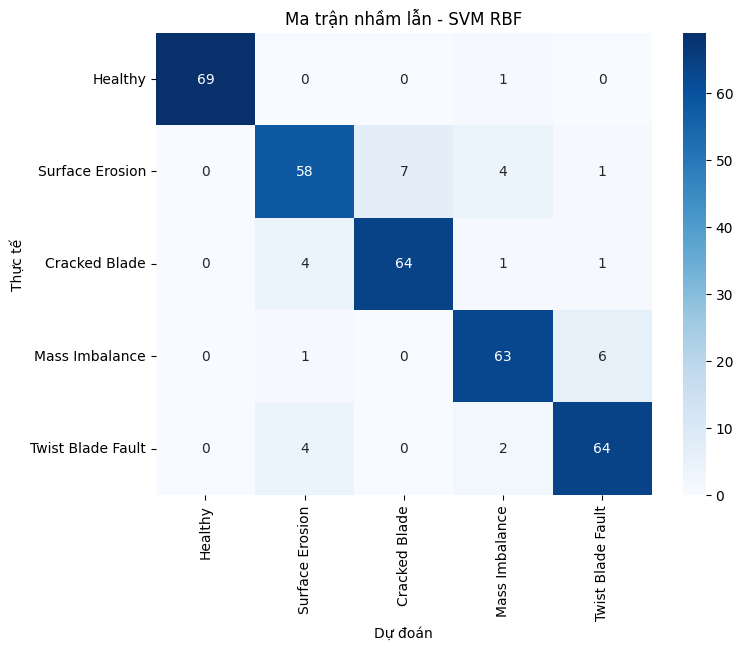

In [8]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐộ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")

target_names = ["Healthy", "Surface Erosion", "Cracked Blade", "Mass Imbalance", "Twist Blade Fault"]
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Ma trận nhầm lẫn - SVM RBF')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.savefig('image/confusion_matrix.png')
plt.show()

# **Cell 9: Vẽ Learning Curve cho Accuracy**

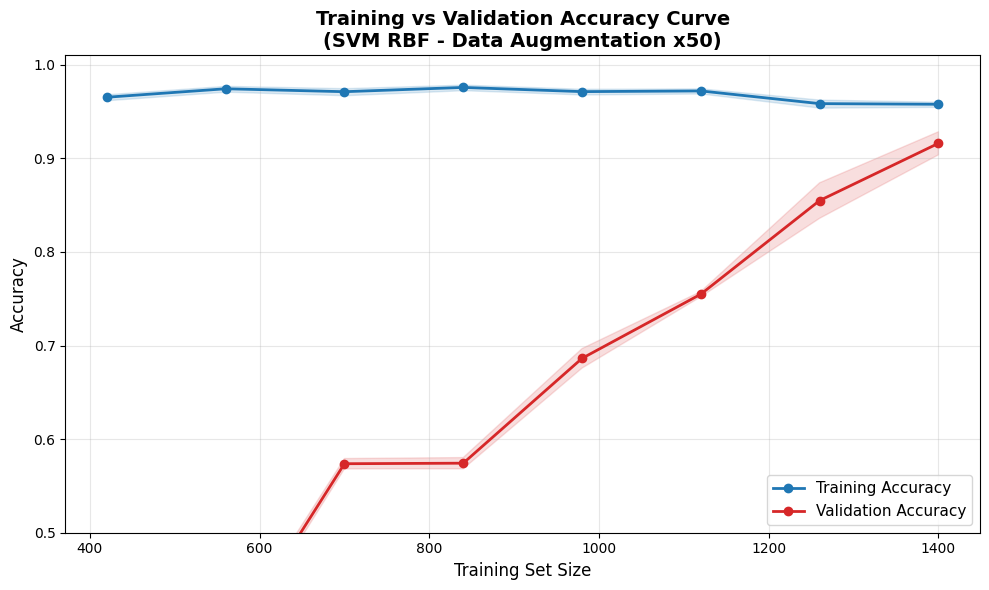

Accuracy cuối cùng:
  - Training:  0.9577 ± 0.0028
  - Validation: 0.9160 ± 0.0123


In [9]:
# Tính learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_reduced, y_aug,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    random_state=42
)

# Tính trung bình và độ lệch
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# VẼ BIỂU ĐỒ
plt.figure(figsize=(10, 6))

# Training Accuracy
plt.plot(train_sizes, train_mean, 'o-', color='#1f77b4', label='Training Accuracy', linewidth=2, markersize=6)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='#1f77b4')

# Validation Accuracy
plt.plot(train_sizes, val_mean, 'o-', color='#d62728', label='Validation Accuracy', linewidth=2, markersize=6)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='#d62728')

# Trang trí
plt.title('Training vs Validation Accuracy Curve\n(SVM RBF - Data Augmentation x50)', fontsize=14, fontweight='bold')
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1.01)
plt.tight_layout()
plt.savefig('image/training_vs_validation_accuracy.png')
plt.show()

# In thông tin
print(f"Accuracy cuối cùng:")
print(f"  - Training:  {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"  - Validation: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")

# **Cell 10: Lưu mô hình**

In [10]:
joblib.dump(best_model, "model/wind_turbine_svm_rbf_model.pkl")
joblib.dump(scaler, "model/wind_turbine_scaler.pkl")
joblib.dump(pca, "model/wind_turbine_pca.pkl")
print("Đã lưu mô hình, scaler và PCA vào thư mục model/")

Đã lưu mô hình, scaler và PCA vào thư mục model/
